In [1]:
function besselsum(p, q, θ)
    ret = besselj(0, p)*besselj(-1, q)*cos(θ)
    i = 1
    nextterm = 1
    while i < 100
        nextterm = besselterm(i, p, q, θ)
        i += 1
        ret += nextterm
    end
    ret
end

function besselterm(n, p, q, θ)
    besselj(n, p)*besselj(-(n+1), q)*cos(n*π/2 + θ) + besselj(-n, p)*besselj(n-1, q)*cos(-n*π/2 + θ) #?
end

besselterm (generic function with 1 method)

In [2]:
R(1, 1, 1.)

LoadError: [91mUndefVarError: R not defined[39m

In [2]:
using SpecialFunctions
using QuantumOptics

function R(n::Int64, m::Int64, ρ::Float64)
    if (n - m) % 2 != 0
        0
    else
        function summand(k)
            n = big(n)
            k = big(k)
            (-1)^k * factorial(n-k)/(factorial(k)*factorial(Int((n+m)/2) - k)*factorial(Int((n-m)/2) - k))*(ρ)^(n-2*k)
        end
        mapreduce(summand, +, Array(range(0, stop=Int((n-m)/2), step=1)))
    end
end

function plot_across_unit_disk(f, discretization)
    x = y = Array(range(-1, 1, length=discretization))
    z = Array{typeof(f(0.,0.))}(UndefInitializer(), length(x), length(y))
    for (i, xx) in enumerate(x)
        for (j, yy) in enumerate(y)
            if xx^2 + yy^2 > 1
                if typeof(f(0.,0.)) == Tuple{Float64,Float64}
                    z[i, j] = (0.,0.)
                else
                    z[i, j] = 0.
                end
            else
                ρ = sqrt(xx^2 + yy^2)
                ϕ = atan(yy, xx)
                res = f(ρ, ϕ)
                z[i, j] = res
            end
        end
    end
    x, y, z
end

function unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    """Each Zernike array is of arbitrary length, but they are ordered by order. The first is Z00 to Zn0 where
    n is the number of 0th order zernike polynomials being considered."""
    Pevens = []
    eventuples = []
    for (n, zeven) in enumerate(zernike_coefficients_even)
        neven = n - 1
        # THERE WAS A BUG IN THE LEGNTH(ZEVEN). IT SHOULD BE RIGHT NOW.
        push!(Pevens, [zeven[i] * R(neven, i-1, ρ) for i in Array(range(1, length(zeven), step=1))])
    end
    for i in range(1, length(Pevens), step=1)
        rotationeven = - (i - 1) * ω * t
        total = 0
        for peven in Pevens
            if length(peven) >= i
                total += peven[i]
            end
        end    
        push!(eventuples, (i - 1, total, rotationeven))
    end

    Podds = []
    oddtuples = []
    for (n, zodd) in enumerate(zernike_coefficients_odd)
        nodd = n - 1
        push!(Podds, [zodd[i] * R(nodd, i-1, ρ) for i in Array(range(1, length(zodd), step=1))])
    end
    for i in range(1, length(Podds), step=1)
        rotationodd = - (i - 1) * ω * t
        total = 0
        for podd in Podds
            if length(podd) >= i
                total += podd[i]
            end
        end    
        push!(oddtuples, (i - 1, total, rotationodd))
    end
    eventuples, oddtuples
end

toarray(s::Union{Set, Array}) = [toarray.(s)...]
toarray(v::Number) = v

toarray (generic function with 2 methods)

In [3]:
function H_odf(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, μ, ω)
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t)
    eventerm = oddterm = 0
    if length(eventuples) > 0
        eventerm = mapreduce(x->x[2]*cos(x[1]*ϕ + x[3]), +, eventuples)
    end
    if length(oddtuples) > 0
        oddterm = mapreduce(x->x[2]*sin(x[1]*ϕ + x[3]), +, oddtuples)
    end
    U * cos(-μ*t + ψ + eventerm + oddterm) 
end

H_odf (generic function with 1 method)

In [4]:
function H_odf_RWA(ρ, ϕ, t, zernike_coefficients_even, zernike_coefficients_odd, U, ψ, ω, m)
    if length(zernike_coefficients_even) > m
        zernike_coefficients_even = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_even[m + 1]])
    else
        zernike_coefficients_even = []
    end
    if length(zernike_coefficients_odd) > m
        zernike_coefficients_odd = vcat([[0] for _ in range(1, m, step=1)], [zernike_coefficients_odd[m + 1]])
    else
        zernike_coefficients_odd = []
    end
    eventuples, oddtuples = unpack_zernike(zernike_coefficients_even, zernike_coefficients_odd, ρ, ω, t) 
    p = q = 0
    if length(eventuples) > 0
        p = eventuples[length(eventuples)][2]
    end
    if length(oddtuples) > 0
        q = oddtuples[length(oddtuples)][2]
    end
    U * besselsum(p, q, -m * ϕ + ψ)
end     

H_odf_RWA (generic function with 1 method)

In [5]:
Γ = 1/62
ω = 2*π*43.8E3
U = 2*π*10E3
θ = 0.;
b = SpinBasis(1//2)
ψ0 = 1/sqrt(2) * (spindown(b) + spinup(b))
evolution_time = 200.0E-6
step_size = evolution_time/1000
T = [0.0:step_size:evolution_time;]
zernikeeven = [[0.], [0., .25]];
zernikeodd = [];
order = 1
μ = order * ω

275203.51645446586

In [6]:
ω = 2*π*43.8E3
ρ = 1.
ϕ = π/2
H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
excitationψ = ψ
# Measure in the x basis
excitation = Real.(expect(sigmax(b), ψ));

In [7]:
H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, order)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

# Measure in the x basis
rwa = Real.(expect(sigmax(b), ψ));
rwaψ = ψ;

In [8]:
ω = 2*π*180E3
μ = order * ω
H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
excitation2ψ = ψ
# Measure in the x basis
excitation2 = Real.(expect(sigmax(b), ψ));

In [9]:
function fidelity(ρ, σ)
    x = real(1 - tr(sqrt(sqrt(ρ) * σ * sqrt(ρ)))^2)
    if x < 0
        x = 0
    end
    x
end


fidelity (generic function with 1 method)

In [11]:
scalefontsizes(1.2)

LoadError: [91mUndefVarError: scalefontsizes not defined[39m

In [10]:
import Pkg; Pkg.add("Measures")

   Updating registry at `~/.julia/registries/General`
######################################################################### 100.0%
  Resolving package versions...
No Changes to `~/.julia/environments/v1.5/Project.toml`
No Changes to `~/.julia/environments/v1.5/Manifest.toml`


In [15]:
10^(maximum([log(10, real(fidelity(ψψ.data,rwaψ[i].data)))  for (i, ψψ) in enumerate(excitationψ)]))

0.050957006821705134

In [14]:
10^(maximum([log(10,real(fidelity(ψψ.data,rwaψ[i].data))) for (i, ψψ) in enumerate(excitation2ψ)]))

0.003066393743992092

┌ Warning: Keyword argument fillstyle not supported with Plots.GRBackend().  Choose from: Set([:top_margin, :group, :background_color, :yforeground_color_text, :yguidefontcolor, :seriesalpha, :seriescolor, :ztick_direction, :zlims, :overwrite_figure, :xguidefonthalign, :normalize, :linestyle, :xflip, :fillcolor, :ygrid, :colorbar_scale, :background_color_inside, :zguidefonthalign, :bins, :legend_font_valign, :yscale, :clims, :xtickfontcolor, :xguide, :fillalpha, :tick_direction, :yguidefontsize, :foreground_color, :xtickfonthalign, :x, :ytickfontrotation, :discrete_values, :ytick_direction, :xguidefontrotation, :ribbon, :tickfontrotation, :xdiscrete_values, :xgridstyle, :orientation, :gridstyle, :markersize, :legend_foreground_color, :camera, :xforeground_color_grid, :quiver, :zticks, :markerstrokecolor, :ztickfontrotation, :ztickfonthalign, :xtickfontsize, :levels, :zgridstyle, :foreground_color_border, :zguidefontvalign, :marker_z, :markerstrokealpha, :markeralpha, :tickfontvalign, :

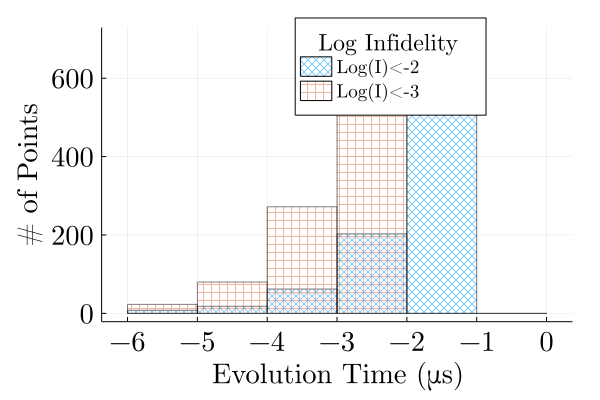

In [11]:
using Plots
using Measures
histogram([log(10, real(fidelity(ψψ.data,rwaψ[i].data)))  for (i, ψψ) in enumerate(excitationψ)], fillstyle=:x, bins=-6:0, xlabel="Evolution Time (μs)", labels="Log(I)<-2", ylabel="# of Points", fontfamily="Computer Modern", alpha=.5, legendtitle="Log Infidelity", legendfontsize=100, legendtitlefontsize=15, yguidefontsize=18, xguidefontsize=18, xtickfontsize=18, ytickfontsize=18, margin=5mm, legend=(.5,.95))
histogram!([log(10,real(fidelity(ψψ.data,rwaψ[i].data))) for (i, ψψ) in enumerate(excitation2ψ)], bins=-6:0, alpha=.5, labels="Log(I)<-3", fillstyle=:+, legendfontsize=12)

In [20]:
maximum([real(fidelity(ψψ.data,rwaψ[i].data)) for (i, ψψ) in enumerate(excitation2ψ)])

0.0030663937439920907

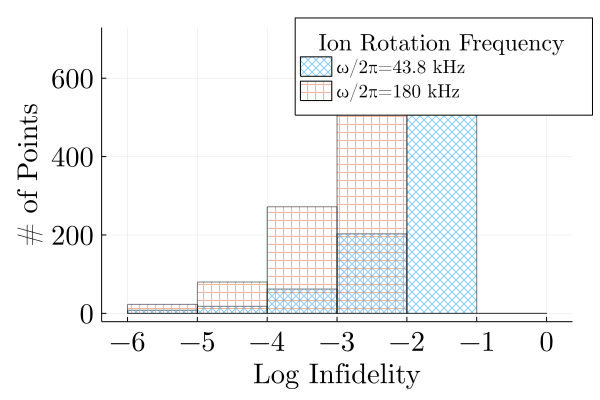

In [14]:
using Plots
using Measures
histogram([log(10, real(fidelity(ψψ.data,rwaψ[i].data)))  for (i, ψψ) in enumerate(excitationψ)], fillstyle=:x, bins=-6:0, xlabel="Log Infidelity", labels="ω/2π=43.8 kHz", ylabel="# of Points", fontfamily="Computer Modern", alpha=.5, legendtitle="Ion Rotation Frequency", legendfontsize=100, legendtitlefontsize=15, yguidefontsize=18, xguidefontsize=18, xtickfontsize=18, ytickfontsize=18, margin=5mm, legend=(.5,.95))
histogram!([log(10,real(fidelity(ψψ.data,rwaψ[i].data))) for (i, ψψ) in enumerate(excitation2ψ)], bins=-6:0, alpha=.5, labels="ω/2π=180 kHz", fillstyle=:+, legendfontsize=12)

In [12]:
maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(excitationψ)])

0.012990184122326331

In [13]:
maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(excitation2ψ)])

0.0007674815258543743

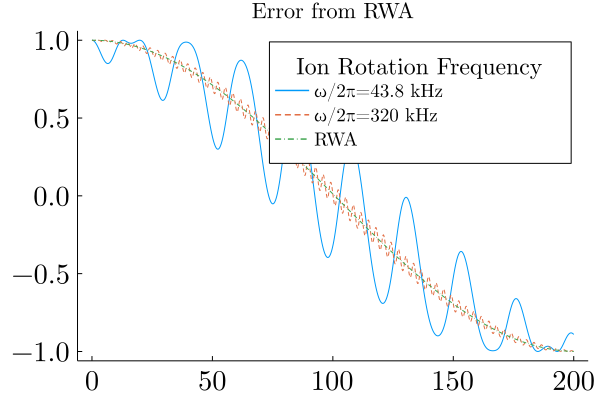

In [41]:
using Plots

#using LaTeXStrings
using Statistics
#f=font(13,"cursive")
#using ColorSchemes
#Plots.scalefontsizes(1/1.25)
#scalefontsizes(1.3)
plot(T*1E6, [excitation, excitation2, rwa], labels=["ω/2π=43.8 kHz" "ω/2π=320 kHz" "RWA"], linestyle=[:auto :dash :dashdot], grid=false, title="Error from RWA",yguidefontsize=200, yguidefontrotation=-90,fontfamily="serif-roman", legendtitle="Ion Rotation Frequency",legendtitlefontsize=15, legendfontsize=12, axisfontsize=18, xtickfontsize=18, ytickfontsize=18, legend=:topright)


In [10]:
#using Plots, PyPlot
#using LaTeXStrings
using Statistics
#f=font(13,"cursive")
#using ColorSchemes
#Plots.scalefontsizes(1/1.25)
#scalefontsizes(1.3)
plot(T*1E6, [excitation, excitation2, rwa], labels=["ω/2π=43.8kHz" "ω/2π=180kHz" "RWA"], linestyle=[:auto :dash :dashdot], grid=false, title="Error from RWA",yguidefontsize=10, yguidefontrotation=-90,fontfamily="serif-roman",xlabel=L"\textrm{Evolution Time}\ (\mu s)", ylabel=L"\left\langle\sigma_x\right\rangle")

LoadError: LoadError: [91mUndefVarError: @L_str not defined[39m
in expression starting at In[10]:8

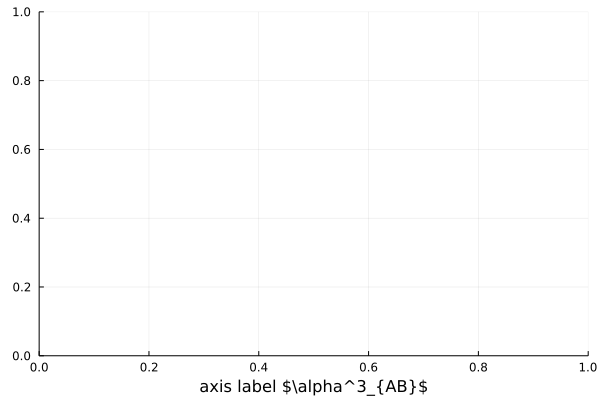

In [47]:
plot(xlabel="axis label \$\\alpha^3_{AB}\$")

In [18]:
using Plots; pyplot()
using LaTeXStrings
using Statistics
#f=font(13,"cursive")
#using ColorSchemes
plot(T*1E6, [rwa, excitation, excitation2], labels=["RWA" "ω=2π43.8E3" "ω=2π180E3"], grid=false, title="Error from RWA", xlabel=L"\mu s", ylabel=L"\langle \sigma_x\rangle", yguidefontrotation=-90, fontfamily="Computer Modern")

KeyError: [91mKeyError: key "set_math_fontfamily" not found[39m

    # U versus \omega

In [ ]:
results = []
for ω in range(2*π*43.8E3, 2*π*180E3, length=10)
    μ = order * ω
    H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    xψ = ψ
    push!(results, maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(xψ)]))
end

In [ ]:
plot(range(2*π*43.8E3, 2*π*180E3, length=10), results, xlabel="ω", ylabel="Maximum Infidelity",grid=false,  legend=false)
plot!(range(2*π*43.8E3, 2*π*180E3, length=10), 1E9 * 1 ./ range(2*π*43.8E3, 2*π*180E3, length=10).^2, xlabel="ω", ylabel="Maximum Infidelity",grid=false,  legend=false)

In [ ]:
using LsqFit

# a two-parameter exponential model
# x: array of independent variables
# p: array of model parameters
# model(x, p) will accept the full data set as the first argument `x`.
# This means that we need to write our model function so it applies
# the model to the full dataset. We use `@.` to apply the calculations
# across all rows.
@. model(x, p) = p[1] + p[4]*1/x + p[2]*1/x^2 + p[3]*1/x^4 + p[5]*1/x^3

In [ ]:
p0 = [0., 0., 0., 0., 0.]
fit = curve_fit(model, range(2*π*43.8E3, 2*π*180E3, length=10), results, p0)

In [ ]:
coef(fit)

In [ ]:
p0 = [0., 0., 1.]
fit = curve_fit(model, range(2*π*43.8E3, 2*π*180E3, length=10), results, p0)
# fit is a composite type (LsqFitResult), with some interesting values:
#	dof(fit): degrees of freedom
#	coef(fit): best fit parameters
#	fit.resid: residuals = vector of residuals
#	fit.jacobian: estimated Jacobian at solution
lb = [1.1, -0.5]
ub = [1.9, Inf]
p0_bounds = [1.2, 1.2] # we have to start inside the bounds 
# Optional upper and/or lower bounds on the free parameters can be passed as an argument.
# Bounded and unbouded variables can be mixed by setting `-Inf` if no lower bounds
# is to be enforced for that variable and similarly for `+Inf`
fit_bounds = curve_fit(model, xdata, ydata, p0_bounds, lower=lb, upper=ub)

# We can estimate errors on the fit parameters,
# to get standard error of each parameter:
sigma = stderror(fit)
# to get margin of error and confidence interval of each parameter at 5% significance level:
margin_of_error = margin_error(fit, 0.05)
confidence_inter = confidence_interval(fit, 0.05)

# The finite difference method is used above to approximate the Jacobian.
# Alternatively, a function which calculates it exactly can be supplied instead.
function jacobian_model(x,p)
    J = Array{Float64}(undef, length(x), length(p))
    @. J[:,1] = exp(-x*p[2])     #dmodel/dp[1]
    @. @views J[:,2] = -x*p[1]*J[:,1] #dmodel/dp[2], thanks to @views we don't allocate memory for the J[:,1] slice
    J
end
fit = curve_fit(model, jacobian_model, xdata, ydata, p0)

In [ ]:
results = []
for U in range(2*π*10E1, 2*π*10E4, length=30)   
    evolution_time = 2*π*10E3/U * 200.0E-6
    step_size = evolution_time/100
    T = [0.0:step_size:evolution_time;]
    ω = 2*π*180E3
    μ = order * ω
    H(t, _) = H_odf(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, μ, ω)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])
    xψ = ψ
    H(t, _) = H_odf_RWA(ρ, ϕ, t, zernikeeven, zernikeodd, U, θ, ω, order)*sigmaz(b), [sigmam(b)], [dagger(sigmam(b))]
    tout, ψ = timeevolution.master_dynamic(T, ψ0, H; rates=[Γ])

    # Measure in the x basis
    rwa = Real.(expect(sigmax(b), ψ));
    rwaψ = ψ;
    push!(results, maximum([real(fidelity(ψψ.data,rwaψ[i].data))  for (i, ψψ) in enumerate(xψ)]))
end

In [ ]:
plot(range(2*π*43.8E3, 2*π*180E3, length=30), results, xlabel="U", ylabel="Maximum Infidelity",grid=false,  legend=false)
plot!(range(2*π*43.8E3, 2*π*180E3, length=30), .7E-13*range(2*π*43.8E3, 2*π*180E3, length=30).^2 .-.005)

In [ ]:
@. model(x, p) = p[1] + p[2] * x + p[3] * x^2 + p[4] * x^4
p0 = [1., 1., 1., 1.]
fit = curve_fit(model, range(2*π*43.8, 2π*180, length=10)[1:end-1], 10000000*results[1:end-1], p0)

In [ ]:
coef(fit)